In [1]:
import h5py
import numpy as np
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,Dense,Conv2D,MaxPooling2D,UpSampling2D,Flatten,add
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
save = True # should models be saved? Warning: Will overwrite previously trained models

In [3]:
tf.keras.backend.clear_session()

In [4]:
f = h5py.File('data/phase_diagram_rephased.h5', 'r')

In [5]:
phase = f["parameter"]["phase"][:]
freq = f["parameter"]["freq"][:]

In [6]:
uphase = np.unique(phase)
ufreq = np.unique(freq)
X,Y = np.meshgrid(uphase,ufreq)

In [7]:
def train_mask(freq0,freq1,phase0,phase1):
    pick_freq = np.where((freq >= freq0) & (freq <= freq1))
    pick_phase = np.where((phase >= phase0) & (phase <= phase1))
    return np.intersect1d(pick_freq,pick_phase)

In [8]:
print(freq.min(),freq.max(),phase.min(),phase.max())

5.1000000000000005 7.8 -180.0 180.0


In [9]:
images = f["images"][:][:,:,:,np.newaxis]
images.shape

(10436, 56, 56, 1)

In [10]:
images_flipped = np.flip(images,axis=1)

In [11]:
# Theory data
file = h5py.File("phase_diagram_theory.h5","r")
file.keys()

chern_number = file["chern_number"][:]
freq0 = file["freq"][:]
phase0 = file["phase"][:]

x0,y0 = np.meshgrid(phase0,freq0)

In [12]:
rate=0.2 # Dropout percentage
bottleneck = 50 # latent space dimension, does not make great differences

In [13]:
def ConvFully2(loss,optimizer,activation0,activation,x_shape,dim1=(16,(3,3)),dim2=(16,(3,3))):
    """ 
    Pretty Standard Convolutional Autoencoder with a fully-connected latent space
    activation0: Activations "inside" the CAE
    activation: Last activation (important depending on the range of the pixel values)
    """
    in_dim = x_shape
    input_img = Input(shape=in_dim)
   
    x1 = Conv2D(*dim1, activation=activation0, padding='same')(input_img)
    x2 = MaxPooling2D((2, 2), padding='same')(x1)
    x2 = Conv2D(*dim2, activation=activation0, padding='same')(x2)
    x3 = MaxPooling2D((2, 2), padding='same')(x2)
    encoded = Conv2D(*dim2, activation=activation0, padding='same')(x3)
    
    encoded = Flatten()(encoded)
    encoded = Dense(units=50,activation=activation0)(encoded)
    encoded = tf.keras.layers.Dropout(rate)(encoded)
    encoded = Dense(dim2[0]*14*14,activation=activation0)(encoded)
    encoded = tf.keras.layers.Dropout(rate)(encoded)
    encoded = tf.keras.layers.Reshape((14,14,dim2[0]))(encoded)

    y=UpSampling2D((2, 2))(encoded)
    y=Conv2D(*dim1, activation=activation0, padding='same')(y)
    y=UpSampling2D((2, 2))(y)
    decoded = Conv2D(x_shape[-1], dim1[1], activation=activation, padding='same')(y)

    cnn = Model(input_img, decoded)
    cnn.compile(loss=loss,optimizer=optimizer)
    return cnn

In [14]:
# Show Network architecture
cnn = ConvFully2("mse","adam","linear","relu",x_shape=(56,56,1))
cnn.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 56, 56, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 56, 56, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 16)        2320      
_________________________________________________________________
flatten (Flatten)            (None, 3136)             

In [15]:
def norm2(y_true,y_pred):
    """ just the standard l2 norm, needed for evaluation """
    return np.sqrt(np.sum(np.abs(y_true - y_pred)**2))

def eval_loss(x_batch,y_batch,norm=norm2):
    a = []
    for i in range(x_batch.shape[0]):
        a.append(norm(x_batch[i],y_batch[i]))
    return np.array(a)

def training_run(x_train,choose_cnn=ConvFully2, name = "Appendix-B", provide_cnn = False,
             load_prev=False, num_epochs = 50,  verbose_val=1, batch_size = 16, shuffle=True, early=False,
             loss="mse", activation0 = 'relu', activation = 'linear', optimizer = "adam",
             dim1=(16,(3,3)),dim2=(16,(3,3)),ssc1=False,ssc2=False, training = 0):
    """
    provide_cnn is to continue the training of a cnn
    load_prev is to load a previously trained network under the same paramters
    x_train provide training data
    """
        
    name_string = "{}".format(training)
    CNN_filepath= 'CNN_data/Anomaly-Detection_' + name_string + 'weights.hdf5'

    cnn = choose_cnn(loss,optimizer,activation0,activation,x_train.shape[1:],dim1,dim2) #ssc1, ssc2
    if load_prev:
        cnn.load_weights(CNN_filepath)
    else:
        if provide_cnn:
            cnn = provide_cnn
        # checkpoint
        checkpoint = ModelCheckpoint(CNN_filepath, monitor='val_loss', verbose=0, save_best_only=False, mode='max')
        callbacks_list = [checkpoint]
        if early:
            early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto', baseline=None)#, restore_best_weights=True)
            callbacks_list.append(early_stop)

        history=cnn.fit(x_train, x_train, epochs=num_epochs, batch_size=batch_size,validation_data=(x_train,x_train),callbacks=callbacks_list,verbose=verbose_val,shuffle=shuffle)
        np.savez('CNN_data/Anomaly-Detection_history_cnn_' + name_string + '.npz',loss=history.history['loss'],val_loss=history.history['val_loss'])#,acc=history.history['acc'],val_acc=history.history['val_acc'])

    # training history
    plotname = 'plots/Anomaly-Detection_training-history' +  name_string
    hist = np.load('CNN_data/Anomaly-Detection_history_cnn_' + name_string + '.npz',allow_pickle="True")
    loss = hist["loss"]
    val_loss = hist["val_loss"]
    plt.plot(loss, linewidth=2, label='Train')
    plt.plot(val_loss, linewidth=2, label='Val')
    plt.legend(loc='upper right')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.yscale("log")
    #plt.ylim(ymin=0.70,ymax=1)
    plt.savefig(plotname + 'training.png', format="png")
    plt.show()
    return cnn

In [16]:
def create_out(cnn1, images):
    """
    Creates (dim_freq, dim_phase) matrix of the output loss and the standard deviation
    """
    images_out = cnn1.predict(images)

    res = eval_loss(images,images_out,norm=norm2)/eval_loss(images,0*images,norm=norm2)

    uphase = np.unique(phase)

    ufreq = np.unique(freq)

    X,Y = np.meshgrid(uphase,ufreq)

    out = np.zeros((len(uphase),len(ufreq)))
    dout = np.zeros((len(uphase),len(ufreq)))

    for i,ph in enumerate(uphase):
        for j,fr in enumerate(ufreq):
            mask = np.intersect1d(np.where(freq == fr),np.where(phase == ph))
            out[i,j] = np.mean(res[mask])
            dout[i,j] = np.std(res[mask])
    return 100*out, 100*dout, 100*res

In [17]:
# this is here the results, i.e. the loss values and its error are going to be saved
# res is the full-stack data list while out is averaged and aranged
cnns, outs, douts, res = [None] * 3,[None] * 3, [None] * 3, [None] * 3 

In [18]:
train_freqss = []
train_phasess = []

# 1 Training in with small boxes on normal images

## 1.1 Low Freqs

In [19]:
tf.keras.backend.clear_session()

In [20]:
training = 0

In [21]:
train_freqs = [(5.3,5.5)]
train_phases = [(-130,-50)]
train_freqss.append(train_freqs)
train_phasess.append(train_phases)

[(261, 56, 56, 1)]
(261, 56, 56, 1)


(-180.0, 180.0)

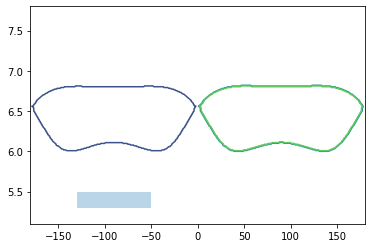

In [22]:
x_train = []
for phases,freqs in zip(train_phases,train_freqs):
    x_train.append(f["images"][train_mask(*freqs,*phases)][:,:,:,np.newaxis])
print([_.shape for _ in x_train])
x_train = np.concatenate(x_train)
print(x_train.shape)
fig, ax = plt.subplots()
ax.contour(x0,y0,np.round(chern_number.T),levels=2)
for phases,freqs in zip(train_phases,train_freqs):
    plt.fill_between(*[phases],*freqs,alpha=0.3)
plt.ylim(freq.min(),freq.max())
plt.xlim(phase.min(),phase.max())

Epoch 1/50
17/17 [==============================] - 0s 29ms/step - loss: 0.1117 - val_loss: 0.0146
Epoch 2/50
17/17 [==============================] - 0s 15ms/step - loss: 0.0215 - val_loss: 0.0098
Epoch 3/50
17/17 [==============================] - 0s 15ms/step - loss: 0.0143 - val_loss: 0.0055
Epoch 4/50
17/17 [==============================] - 0s 16ms/step - loss: 0.0109 - val_loss: 0.0076
Epoch 5/50
17/17 [==============================] - 0s 15ms/step - loss: 0.0098 - val_loss: 0.0041
Epoch 6/50
17/17 [==============================] - 0s 16ms/step - loss: 0.0084 - val_loss: 0.0050
Epoch 7/50
17/17 [==============================] - 0s 15ms/step - loss: 0.0076 - val_loss: 0.0036
Epoch 8/50
17/17 [==============================] - 0s 15ms/step - loss: 0.0070 - val_loss: 0.0047
Epoch 9/50
17/17 [==============================] - 0s 16ms/step - loss: 0.0065 - val_loss: 0.0035
Epoch 10/50
17/17 [==============================] - 0s 15ms/step - loss: 0.0055 - val_loss: 0.0034
Epoch 11/

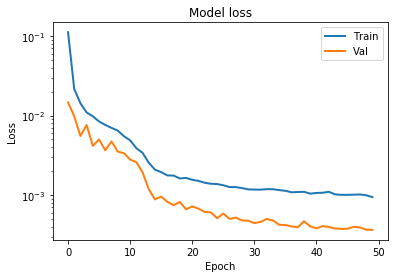

In [23]:
cnns[training] = training_run(x_train, load_prev=False, training = training)

## 1.2 Topological

In [24]:
tf.keras.backend.clear_session()

In [25]:
training = 1

In [26]:
train_freqs = [(6.4,6.6)]
train_phases = [(-130,-50)]
train_freqss.append(train_freqs)
train_phasess.append(train_phases)

[(261, 56, 56, 1)]
(261, 56, 56, 1)


(-180.0, 180.0)

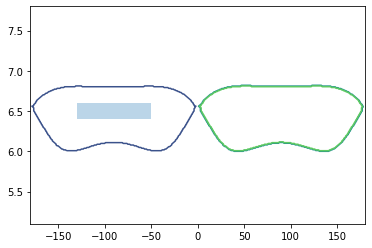

In [27]:
x_train = []
for phases,freqs in zip(train_phases,train_freqs):
    x_train.append(f["images"][train_mask(*freqs,*phases)][:,:,:,np.newaxis])
print([_.shape for _ in x_train])
x_train = np.concatenate(x_train)
print(x_train.shape)
fig, ax = plt.subplots()
ax.contour(x0,y0,np.round(chern_number.T),levels=2)
for phases,freqs in zip(train_phases,train_freqs):
    plt.fill_between(*[phases],*freqs,alpha=0.3)
plt.ylim(freq.min(),freq.max())
plt.xlim(phase.min(),phase.max())

Epoch 1/50
17/17 [==============================] - 0s 24ms/step - loss: 0.1775 - val_loss: 0.0345
Epoch 2/50
17/17 [==============================] - 0s 14ms/step - loss: 0.0283 - val_loss: 0.0171
Epoch 3/50
17/17 [==============================] - 0s 15ms/step - loss: 0.0172 - val_loss: 0.0076
Epoch 4/50
17/17 [==============================] - 0s 14ms/step - loss: 0.0126 - val_loss: 0.0060
Epoch 5/50
17/17 [==============================] - 0s 15ms/step - loss: 0.0099 - val_loss: 0.0066
Epoch 6/50
17/17 [==============================] - 0s 16ms/step - loss: 0.0085 - val_loss: 0.0052
Epoch 7/50
17/17 [==============================] - 0s 16ms/step - loss: 0.0077 - val_loss: 0.0061
Epoch 8/50
17/17 [==============================] - 0s 15ms/step - loss: 0.0070 - val_loss: 0.0043
Epoch 9/50
17/17 [==============================] - 0s 16ms/step - loss: 0.0064 - val_loss: 0.0047
Epoch 10/50
17/17 [==============================] - 0s 17ms/step - loss: 0.0058 - val_loss: 0.0039
Epoch 11/

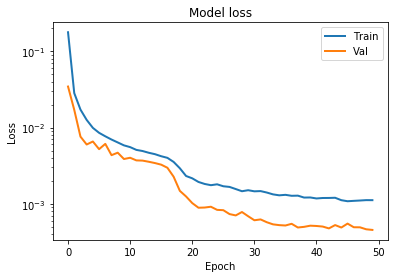

In [28]:
cnns[training] = training_run(x_train, load_prev=False, training = training)

## 1.3 High Freqs

In [29]:
tf.keras.backend.clear_session()

In [30]:
training = 2

In [31]:
train_freqs = [(7.3,7.5)]
train_phases = [(-130,-50)]
train_freqss.append(train_freqs)
train_phasess.append(train_phases)

[(261, 56, 56, 1)]
(261, 56, 56, 1)


(-180.0, 180.0)

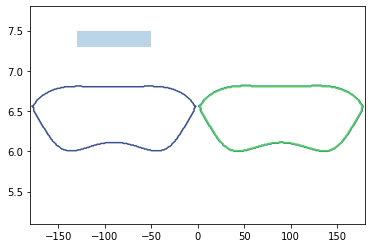

In [32]:
x_train = []
for phases,freqs in zip(train_phases,train_freqs):
    x_train.append(f["images"][train_mask(*freqs,*phases)][:,:,:,np.newaxis])
print([_.shape for _ in x_train])
x_train = np.concatenate(x_train)
print(x_train.shape)
fig, ax = plt.subplots()
ax.contour(x0,y0,np.round(chern_number.T),levels=2)
for phases,freqs in zip(train_phases,train_freqs):
    plt.fill_between(*[phases],*freqs,alpha=0.3)
plt.ylim(freq.min(),freq.max())
plt.xlim(phase.min(),phase.max())

Epoch 1/50
17/17 [==============================] - 0s 25ms/step - loss: 0.1330 - val_loss: 0.0185
Epoch 2/50
17/17 [==============================] - 0s 15ms/step - loss: 0.0236 - val_loss: 0.0126
Epoch 3/50
17/17 [==============================] - 0s 16ms/step - loss: 0.0150 - val_loss: 0.0101
Epoch 4/50
17/17 [==============================] - 0s 16ms/step - loss: 0.0128 - val_loss: 0.0073
Epoch 5/50
17/17 [==============================] - 0s 15ms/step - loss: 0.0101 - val_loss: 0.0059
Epoch 6/50
17/17 [==============================] - 0s 16ms/step - loss: 0.0093 - val_loss: 0.0065
Epoch 7/50
17/17 [==============================] - 0s 16ms/step - loss: 0.0082 - val_loss: 0.0061
Epoch 8/50
17/17 [==============================] - 0s 16ms/step - loss: 0.0075 - val_loss: 0.0061
Epoch 9/50
17/17 [==============================] - 0s 16ms/step - loss: 0.0068 - val_loss: 0.0057
Epoch 10/50
17/17 [==============================] - 0s 16ms/step - loss: 0.0065 - val_loss: 0.0053
Epoch 11/

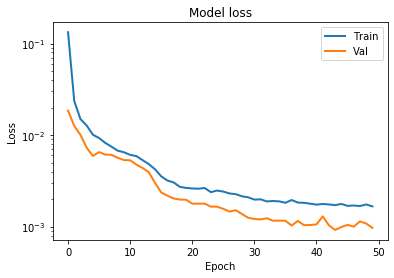

In [33]:
cnns[training] = training_run(x_train, load_prev=False, training = training)

In [34]:
outs, douts, outs2, douts2= [None]*3,[None]*3,[None]*3,[None]*3

In [35]:
# gonna use these results below, need to calculate them here because gonna overwrite the freq and phase variables now
for i in range(3):
    outs[i],douts[i],_ = create_out(cnns[i],images)
    outs2[i],douts2[i],_ = create_out(cnns[i],images_flipped)

# 2 Training in with small boxes on normal AND flipped images

In [36]:
cnns2 = [None] * 3

In [37]:
phase0 = f["parameter"]["phase"][:]
freq0 = f["parameter"]["freq"][:]

In [38]:
phase = np.concatenate([phase0,phase0])
freq = np.concatenate([freq0,freq0])

In [39]:
uphase = np.unique(phase)
ufreq = np.unique(freq)
X,Y = np.meshgrid(uphase,ufreq)

In [40]:
images = f["images"][:][:,:,:,np.newaxis]
images.shape

(10436, 56, 56, 1)

In [41]:
images = np.concatenate([images,np.flip(images,axis=1)])
images.shape

(20872, 56, 56, 1)

## 2.1 Low Freqs

In [42]:
tf.keras.backend.clear_session()

In [43]:
training = 0

In [44]:
x_train = []
for phases,freqs in zip(train_phasess[training],train_freqss[training]):
    x_train.append(images[train_mask(*freqs,*phases)])
x_train = np.concatenate(x_train)

Epoch 1/50
33/33 [==============================] - 1s 19ms/step - loss: 0.0461 - val_loss: 0.0115
Epoch 2/50
33/33 [==============================] - 0s 12ms/step - loss: 0.0130 - val_loss: 0.0063
Epoch 3/50
33/33 [==============================] - 0s 13ms/step - loss: 0.0101 - val_loss: 0.0062
Epoch 4/50
33/33 [==============================] - 0s 13ms/step - loss: 0.0076 - val_loss: 0.0037
Epoch 5/50
33/33 [==============================] - 0s 13ms/step - loss: 0.0048 - val_loss: 0.0031
Epoch 6/50
33/33 [==============================] - 0s 13ms/step - loss: 0.0036 - val_loss: 0.0018
Epoch 7/50
33/33 [==============================] - 0s 13ms/step - loss: 0.0030 - val_loss: 0.0015
Epoch 8/50
33/33 [==============================] - 0s 13ms/step - loss: 0.0025 - val_loss: 0.0014
Epoch 9/50
33/33 [==============================] - 0s 13ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 10/50
33/33 [==============================] - 0s 13ms/step - loss: 0.0019 - val_loss: 8.0052e-04
Epoch

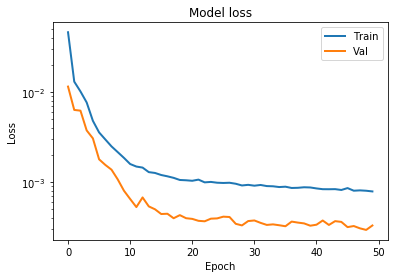

In [45]:
cnns2[training] = training_run(x_train, load_prev=False, training = training)

## 2.2 Topological

In [46]:
tf.keras.backend.clear_session()

In [47]:
training = 1

In [48]:
x_train = []
for phases,freqs in zip(train_phasess[training],train_freqss[training]):
    x_train.append(images[train_mask(*freqs,*phases)])
x_train = np.concatenate(x_train)

Epoch 1/50
33/33 [==============================] - 1s 17ms/step - loss: 0.0494 - val_loss: 0.0125
Epoch 2/50
33/33 [==============================] - 0s 13ms/step - loss: 0.0157 - val_loss: 0.0098
Epoch 3/50
33/33 [==============================] - 0s 13ms/step - loss: 0.0091 - val_loss: 0.0032
Epoch 4/50
33/33 [==============================] - 0s 12ms/step - loss: 0.0060 - val_loss: 0.0031
Epoch 5/50
33/33 [==============================] - 0s 13ms/step - loss: 0.0047 - val_loss: 0.0026
Epoch 6/50
33/33 [==============================] - 0s 13ms/step - loss: 0.0037 - val_loss: 0.0017
Epoch 7/50
33/33 [==============================] - 0s 13ms/step - loss: 0.0030 - val_loss: 0.0012
Epoch 8/50
33/33 [==============================] - 0s 13ms/step - loss: 0.0023 - val_loss: 8.7195e-04
Epoch 9/50
33/33 [==============================] - 0s 13ms/step - loss: 0.0022 - val_loss: 8.7712e-04
Epoch 10/50
33/33 [==============================] - 0s 13ms/step - loss: 0.0020 - val_loss: 8.6311e-

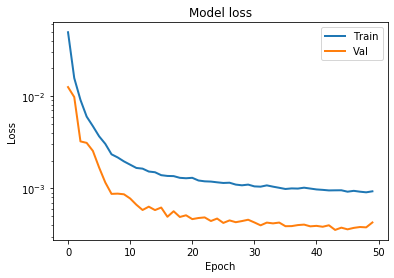

In [49]:
cnns2[training] = training_run(x_train, load_prev=False, training = training)

## 2.3 High Freqs

In [50]:
tf.keras.backend.clear_session()

In [51]:
training = 2

In [52]:
x_train = []
for phases,freqs in zip(train_phasess[training],train_freqss[training]):
    x_train.append(images[train_mask(*freqs,*phases)])
x_train = np.concatenate(x_train)

Epoch 1/50
33/33 [==============================] - 1s 18ms/step - loss: 0.1149 - val_loss: 0.0184
Epoch 2/50
33/33 [==============================] - 0s 14ms/step - loss: 0.0191 - val_loss: 0.0116
Epoch 3/50
33/33 [==============================] - 0s 13ms/step - loss: 0.0154 - val_loss: 0.0108
Epoch 4/50
33/33 [==============================] - 0s 13ms/step - loss: 0.0132 - val_loss: 0.0103
Epoch 5/50
33/33 [==============================] - 0s 13ms/step - loss: 0.0119 - val_loss: 0.0099
Epoch 6/50
33/33 [==============================] - 0s 13ms/step - loss: 0.0105 - val_loss: 0.0080
Epoch 7/50
33/33 [==============================] - 0s 13ms/step - loss: 0.0076 - val_loss: 0.0053
Epoch 8/50
33/33 [==============================] - 0s 13ms/step - loss: 0.0064 - val_loss: 0.0047
Epoch 9/50
33/33 [==============================] - 0s 13ms/step - loss: 0.0055 - val_loss: 0.0037
Epoch 10/50
33/33 [==============================] - 0s 13ms/step - loss: 0.0045 - val_loss: 0.0027
Epoch 11/

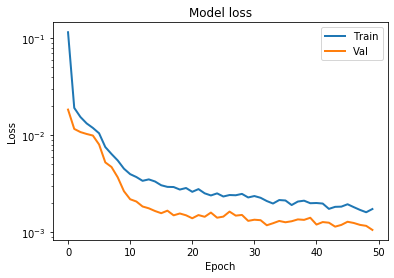

In [53]:
cnns2[training] = training_run(x_train, load_prev=False, training = training)

# 3 Plotting

In [54]:
# for consistency with co-authors
face_colors = {
    'orange': [0.8906, 0.4609, 0.4062],
    'gray': [0.6523, 0.6484, 0.6484],
    'blue': [0.5156, 0.5977, 0.8789]
}
edge_colors = {
    'orange': [0.9961, 0, 0],
    'gray': [0.4805, 0.4766, 0.4766],
    'blue': [0, 0, 0.9961]
}

edge_colors_arr = [ec for ec in edge_colors.values()]
face_colors_arr = [fc for fc in face_colors.values()]

cycler = (plt.cycler(mec=edge_colors_arr)+
          plt.cycler(mfc=face_colors_arr)+
          plt.cycler(color=edge_colors_arr))

plt.rcParams.update({
    #'figure.figsize': (12, 8),
    'font.size': 12,
    #'lines.markeredgewidth': 2,
    #'lines.markersize': 9,
    #'lines.marker': 'x',
    #'lines.linestyle': '-',
    #'lines.linewidth': 3,
    'axes.prop_cycle': cycler
    })

In [55]:
outs3, douts3 = [None]*3,[None]*3,

In [56]:
for i in range(3):
    outs3[i],douts3[i],_ = create_out(cnns2[i],images)

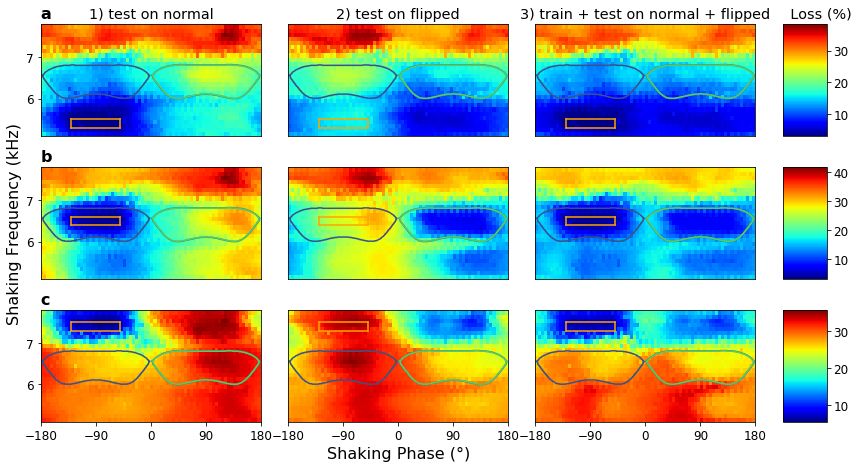

In [73]:
fig, axs = plt.subplots(nrows=3,ncols=4,gridspec_kw={'width_ratios': [1,1,1,0.2]},figsize=(12,6.5))
titles = ["tested on normal","tested on flipped"]
rectcolor="orange"
for training in range(3):
    vmin, vmax = np.min([np.min(outs[training]),np.min(outs2[training]),np.min(outs3[training])]), np.max([np.max(outs[training]),np.max(outs2[training]),np.max(outs3[training])])
    axs[training,0].pcolormesh(X,Y,outs[training].T,vmin=vmin, vmax=vmax, cmap="jet", rasterized=True)
    axs[training,1].pcolormesh(X,Y,outs2[training].T,vmin=vmin, vmax=vmax, cmap="jet", rasterized=True)
    ax = axs[training,2]
    im = ax.pcolormesh(X,Y,outs3[training].T,cmap="jet",vmin=vmin, vmax=vmax, rasterized=True)
    fig.colorbar(im, cax=axs[training,-1])

    for ax in [axs[training,0],axs[training,1],axs[training,2]]:
        ax.contour(x0,y0,np.round(chern_number.T),levels=2)
        ax.set_xlim(uphase.min(),uphase.max())
        ax.set_ylim(ufreq.min(),ufreq.max())
        for phases,freqs in zip(train_phasess[training],train_freqss[training]):
            # I am sure this can be done more elegantly, but aint nobody got time for that:
            ax.plot(phases,[freqs[0]]*2,"-",color=rectcolor)
            ax.plot(phases,[freqs[1]]*2,"-",color=rectcolor)
            ax.plot([phases[0]]*2,freqs,"-",color=rectcolor)
            ax.plot([phases[1]]*2,freqs,"-",color=rectcolor)

plt.tight_layout()

plt.gcf().subplots_adjust(top=0.95,bottom=0.1,left=0.05)
axs[1,0].set_ylabel("Shaking Frequency (kHz)",fontsize=16)
axs[-1,1].set_xlabel("Shaking Phase (°)",fontsize=16)

axs[0,-1].set_title("       Loss (%)")
axs[0,0].set_title("1) test on normal")
axs[0,1].set_title("2) test on flipped")
axs[0,2].set_title("3) train + test on normal + flipped")

for ax in [axs[_] for _ in [(0,0),(0,1),(0,2),(1,0),(1,1),(1,2)]]:
    ax.set_xticks([])
for ax in [axs[_] for _ in [(0,1),(1,1),(2,1),(0,2),(1,2),(2,2)]]:
    ax.set_yticks([])
for ax in [axs[-1,_] for _ in range(3)]:
    ax.set_xticks([-180,-90,0,90,180])
axs[0,0].text(0, 1.05,"a",weight="bold", transform = axs[0,0].transAxes,fontsize=16)
axs[1,0].text(0, 1.05,"b",weight="bold", transform = axs[1,0].transAxes,fontsize=16)
axs[2,0].text(0, 1.05,"c",weight="bold", transform = axs[2,0].transAxes,fontsize=16)



plt.savefig("plots/appendix-flipped-business.pdf",dpi=300)